## LipSDP (Lipschitz Constant Estimation via Semi-Definite Programming) using CVXPY

Here, we are asked to find an estimation of the Lipschitz constant for a single layer Neural Network with the ReLU Activation Function. We provide estimates using two different functions and compare the two. While the first does it by computing the **Spectral Norm** of the weight matrix, the second one does it using the **DCP System of CVXPY by deploying LipSDP**.

In [1]:
# importing necessary libraries
import cvxpy as cp
import numpy as np

the function: *lipschitz_constant_1* computes the lipschitz constant simply by computing the **Spectral Norm** of the weights since it is a single layer neural network 

In [2]:
def lipschitz_constant_1(W):
    # computes 2-norm also known as Spectral norm
    lipschitz_constant = np.linalg.norm(W, ord=2)
    return lipschitz_constant

In [3]:
# test case 1
W = np.array([[1, 0],[0, 1]]) # weight matrix

lipschitz_constant = lipschitz_constant_1(W)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 1.0


In [4]:
# test case 2
W = np.array([[62, 10],[-19, 10]]) # weight matrix

lipschitz_constant = lipschitz_constant_1(W)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 65.19698634456758


In [5]:
# test case 3
W = np.array([[1020, 35783],[3, 371]]) # weight matrix

lipschitz_constant = lipschitz_constant_1(W)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 35799.45644372084


In [6]:
# test case 4
W = np.array([[78, 10, 100],[-259, 23, 0], [94, 60, 11]]) # weight matrix

lipschitz_constant = lipschitz_constant_1(W)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 288.2295695950867


In [7]:
# test case 5
W = np.array([[1, 0, 0, 0],[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]) # weight matrix

lipschitz_constant = lipschitz_constant_1(W)
print(f"Lipschitz constant: {lipschitz_constant}")

Lipschitz constant: 1.0


the function: *lipschitz_constant_2* uses CVXPY which follows **Disciplined Convex Programming (DCP)** system to solve the given convex optimization problem

### We use the following theorem to formulate the Semi Definite Program: 

Details of the Theorem can be found in this paper: https://arxiv.org/pdf/1906.04893.pdf

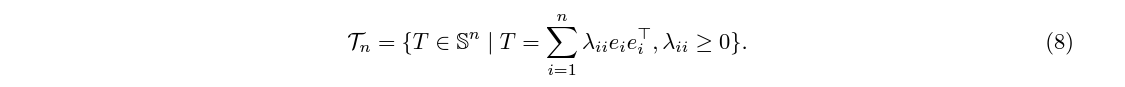

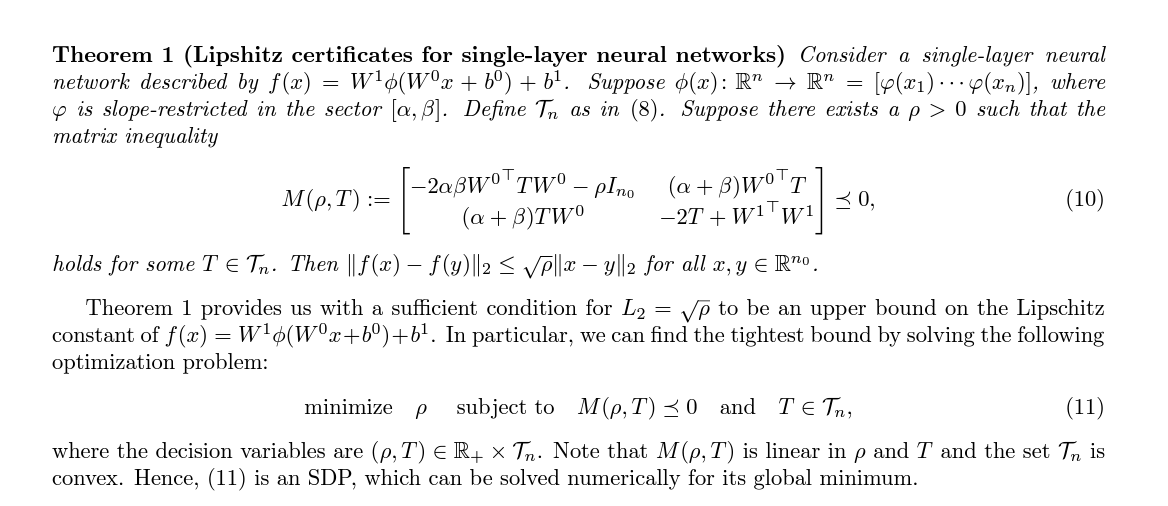

In [8]:
def lipschitz_constant_2(W0, W1, b0, b1, alpha, beta):
    
    n = W0.shape[1]  # number of columns in W0 (hidden layer size)
    m = W1.shape[0]  # number of rows in W1 (number of neurons in the hidden layer)

    # defining the decision variable
    rho = cp.Variable(nonneg=True)
    diag_entries = cp.Variable(m, nonneg=True)
    Tm = cp.diag(diag_entries)

    # defining the matrix inequality M(ρ, Tm)
    M_upper_left = -2 * alpha * beta * (W0.T @ Tm @ W0) - rho * np.eye(W0.shape[0])
    M_upper_right = (alpha + beta) * (W0.T @ Tm)
    M_lower_left = (alpha + beta) * (Tm @ W0)
    M_lower_right = -2 * Tm + W1.T @ W1

    # constructing the block matrix M(ρ, Tm)
    M = cp.bmat([
        [M_upper_left, M_upper_right],
        [M_lower_left, M_lower_right]
    ])

    # defining the constraints
    # M(ρ, Tm) is negative semidefinite and Tm has only positive diagonal entries
    constraints = [M << 0, diag_entries >= 0]

    # defining the objective function
    objective = cp.Minimize(rho)

    # defining the problem
    problem = cp.Problem(objective, constraints)
    
    # solving the problem
    problem.solve()
    
    if problem.status not in ["infeasible", "unbounded"]:
        lipschitz_constant = np.sqrt(rho.value)
        return lipschitz_constant
    else:
        return None


**Note:** As we can see in the above theorem and function, the lipschitz constant does not depend on b0 and b1. So we initialize them randomly, according to their dimenion compatibility.

We set the values of alpha and beta considering the activation function is slope restricted between [alpha, beta].


In [9]:
alpha = 0.0  # setting alpha = 0
beta = 1.0   # setting beta = 1

In [10]:
# test case 1
W0 = np.array([[1, 0],[0, 1]]) 
W1 = np.array([[1, 0], [0, 1]])
b0 = np.array([1, 1])
b1 = np.array([1, 1])

lipschitz_constant = lipschitz_constant_2(W0, W1, b0, b1, alpha, beta)
print("Lipschitz constant:", lipschitz_constant)

Lipschitz constant: 1.0000025938862902


In [15]:
# test case 2
W0 = np.array([[62, 10],[-19, 10]]) 
W1 = np.array([[1, 0],[0, 1]]) 
b0 = np.random.randn(2)     
b1 = np.random.randn(2) 

lipschitz_constant = lipschitz_constant_2(W0, W1, b0, b1, alpha, beta)
print("Lipschitz constant:", lipschitz_constant)

Lipschitz constant: 64.61611223542766


In [12]:
# test case 3
W0 = np.array([[1020, 35783],[3, 371]]) 
W1 = np.array([[1, 0],[0, 1]]) 
b0 = np.random.randn(2)     
b1 = np.random.randn(2) 

lipschitz_constant = lipschitz_constant_2(W0, W1, b0, b1, alpha, beta)
print("Lipschitz constant:", lipschitz_constant)

Lipschitz constant: 554.6152199638269


In [13]:
# test case 4
W0 = np.array([[78, 10, 100],[-259, 23, 0], [94, 60, 11]]) 
W1 = np.array([[3, 2, 1],[-2, 2, 0], [4, 0, 1]]) 
b0 = np.random.randn(3)     
b1 = np.random.randn(3) 

lipschitz_constant = lipschitz_constant_2(W0, W1, b0, b1, alpha, beta)
print("Lipschitz constant:", lipschitz_constant)

Lipschitz constant: 716.2285144002412


In [14]:
# test case 5
W0 = np.array([[1, 0, 0, 0],[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
W1 = np.array([[1, 0, 0, 0],[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
b0 = np.random.randn(4)     
b1 = np.random.randn(4) 

lipschitz_constant = lipschitz_constant_2(W0, W1, b0, b1, alpha, beta)
print("Lipschitz constant:", lipschitz_constant)

Lipschitz constant: 1.0000004858875091
